In [327]:
import numpy as np
import pylab as plb
import math
import copy
import matplotlib.pyplot as plt
import twoflow as flow
import matplotlib.pyplot as plot
%matplotlib inline

In [328]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as colorbar
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def initialize(timesteps):
    ''' initialize the physical system, horizontal grid size, etc
    '''  
    # below are the parameters that can be varied
    dx = 100.
    u = 0.
    dz = 100.
    v = 0.
    dt = 0.01
    alpha =  0.01*10.
    epsilon = 0.0001
    
# create the concentration matrix and initialize it
    cmatrix=np.zeros((2, Numpoints+4,Numpoints+4))
    c2matrix=np.zeros((2, Numpoints+4,Numpoints+4))
    diss = np.zeros((timesteps+1, Numpoints+4,Numpoints+4))
    part = np.zeros((timesteps+1, Numpoints+4,Numpoints+4))
    
    return dx, dz, u, v, dt, Numpoints, epsilon, cmatrix,c2matrix

def boundary_conditions(cmatrix, time, Numpoints):
    '''Set boundary conditions (double thick so it work for Bott Scheme as well as central and upstream
    '''
    cmatrix[0, 0,:] = cmatrix[1, Numpoints-1,:]
    cmatrix[0, 1,:] = cmatrix[1, Numpoints,:]
    cmatrix[0, Numpoints+2,:] = cmatrix[1, 3,:]
    cmatrix[0, Numpoints+3,:] = cmatrix[1, 4,:]
    
    cmatrix[0, :,0] = cmatrix[1, :,Numpoints-1]
    cmatrix[0, :,1] = cmatrix[1, :,Numpoints]
    cmatrix[0, :,Numpoints+2] = cmatrix[1, :,3]
    cmatrix[0, :,Numpoints+3] = cmatrix[1, :,4]
    
    return cmatrix


def advect3_gettable(order, Numpoints):
    
    '''read in the corresponding coefficient table for the calculation of coefficients for advection3
    '''

# create a matrix to store the table to be read in
    temp = np.zeros(5)
    ltable = np.zeros((order + 1, 5))

    fname = 'numeric/numlabs/lab10/Tables/l{0}_table.txt'.format(order)
    fp = open(fname, 'r')
 
    for i in range(order+1):
        line = fp.readline()
        temp = line.split()
        ltable[i, :]= temp
        
    fp.close()
    return ltable

    
    
def advect_xz(ltable, cmatrix, order, Numpoints, u, v, dt, dx, dz, epsilon):
    '''Step algorithm for Bott Scheme'''
    amatrix = np.zeros((order+1, Numpoints))
    timecount=0
    # concentration in z dir
    for numz in range (2,Numpoints+2):
        for base in range(0,5):
            amatrix[0:order+1, 0:Numpoints] += np.dot(
                ltable[0:order+2, base:base+1], 
                cmatrix[timecount:timecount+1, 0+base:Numpoints+base, numz])

        Iplus = np.zeros(Numpoints)
        Iatj = np.zeros(Numpoints)

        tempvalue= 1 - 2*v*dt/dz
        for k in range(order+1):
            Iplus += amatrix[k] * (1- (tempvalue**(k+1)))/(k+1)/(2**(k+1))
            Iatj += amatrix[k] * ((-1)**k+1)/(k+1)/(2**(k+1))
        Iplus[Iplus < 0] = 0
        Iatj = np.maximum(Iatj, Iplus + epsilon)


        cmatrix[timecount, 3:Numpoints+2,numz] = (
            cmatrix[timecount, 3:Numpoints+2,numz] * 
            (1 - Iplus[1:Numpoints]/ Iatj[1:Numpoints]) + 
             cmatrix[timecount, 2:Numpoints+1,numz]* 
             Iplus[0:Numpoints-1]/ Iatj[0:Numpoints-1])
    # concentration in x dir
    for numx in range (2,Numpoints+2):
        for base in range(0,5):
            amatrix[0:order+1, 0:Numpoints] += np.dot(
                ltable[0:order+2, base:base+1], 
                cmatrix[timecount:timecount+1,numx, 0+base:Numpoints+base])

        Iplus = np.zeros(Numpoints)
        Iatj = np.zeros(Numpoints)

        tempvalue= 1 - 2*u*dt/dx
        for k in range(order+1):
            Iplus += amatrix[k] * (1- (tempvalue**(k+1)))/(k+1)/(2**(k+1))
            Iatj += amatrix[k] * ((-1)**k+1)/(k+1)/(2**(k+1))
        Iplus[Iplus < 0] = 0
        Iatj = np.maximum(Iatj, Iplus + epsilon)


        cmatrix[timecount+1, numx,3:Numpoints+2] = (
            cmatrix[timecount, numx,3:Numpoints+2] * 
            (1 - Iplus[1:Numpoints]/ Iatj[1:Numpoints]) + 
             cmatrix[timecount, numx, 2:Numpoints+1]* 
             Iplus[0:Numpoints-1]/ Iatj[0:Numpoints-1])                      
            
            
        #left boundary
        cmatrix[timecount+1, 2,:]= cmatrix[timecount+1, 3,:]
        #surface boundary
        cmatrix[timecount+1, :,2]= cmatrix[timecount+1, :,3]
        #right boundary
        cmatrix[timecount+1, Numpoints+2,:]= cmatrix[timecount+1, Numpoints+1,:]
        #bottom boundary
        cmatrix[timecount+1, :,Numpoints+2]= cmatrix[timecount+1, :,Numpoints+1]

    return cmatrix[timecount+1, :,:]


def tracer(diss,part,timesteps, order):
    dx, dz,u, v,dt, Numpoints, epsilon, cmatrix, c2matrix = initialize(timesteps)

    for t in range (timesteps): 
        for z in range (Numpoints+2):
        #chem model
            part[2,:]=0
            
            diss_pre=diss
            part_pre=part
            diss += ( Q - k_ad[z,:] * diss_pre + k_de * part_pre) * dt
            
            if z!=0:
                sinking=500*(part_pre[z,:]-part_pre[z-1,:])/dz
                part[z,:] += ( k_ad[z,:] * diss_pre[z,:]- k_de * part_pre[z,:] - sinking) * dt
            else:
                part[z,:] =0
    return diss,part

def plot(Hu,x,y,timestep,j1,j2,j3):
    
    ax = fig.add_subplot(j1, j2, j3+1)
    X = np.linspace(0, x,x,endpoint=False)
    Y = np.linspace(0, y,y,endpoint=False)
    X, Y = np.meshgrid(X, Y)
    Z = Hu[2:-2,2:-2]#(Hu**2+Hv**2)**0.5
    
    plt.pcolor(X, Y, Z)
    ax.set_title('t:%syr'%(timestep+1))
    ax.invert_yaxis()
    plt.colorbar()    

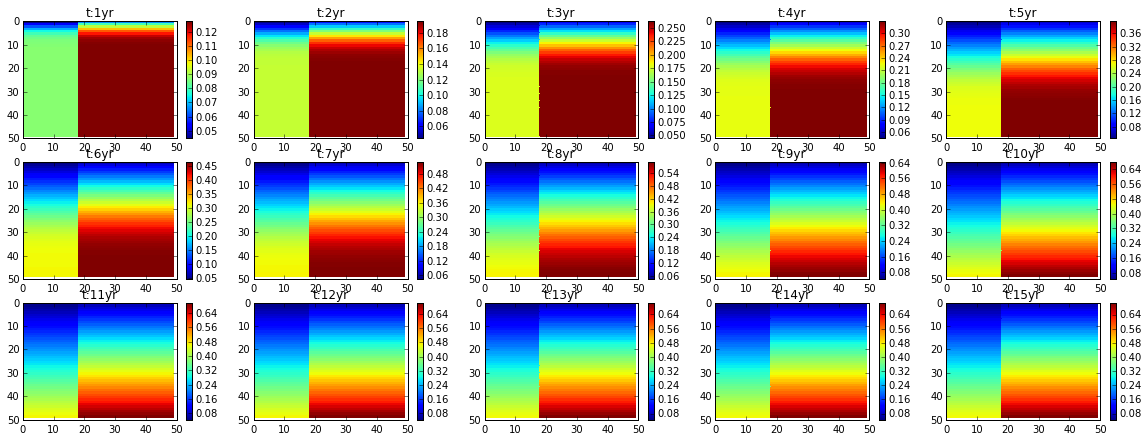

In [329]:
coeff=100
yr=15
t=yr*coeff
Numpoints = 50

# chemistry
k_ad = np.zeros((Numpoints+4,Numpoints+4))
k_ad[:,:]=0.6
k_ad[:,20:]=0.4
k_de= 1.0
Q =0.0267 

diss = np.zeros((Numpoints+4,Numpoints+4))
disst= np.zeros((yr,Numpoints+4,Numpoints+4))
part = np.zeros((Numpoints+4,Numpoints+4))
partt= np.zeros((yr,Numpoints+4,Numpoints+4))

fig = plt.figure(figsize=(20,50))
for j in range (t):
    diss,part=tracer(diss,part,1,4)
    k=(j+1)%coeff
    if k==0 and j!=0:
        disst[j/coeff,:,:]=diss
        partt[j/coeff,:,:]=part
        plot(diss,Numpoints,Numpoints,timestep=j/coeff,j1=20,j2=5,j3=j/coeff)
plt.show()

In [330]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as colorbar
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm




def initialize(timesteps):
    ''' initialize the physical system, horizontal grid size, etc
    '''  
    # below are the parameters that can be varied
    dx = 100
    u = 0.
    dz = 100
    v = 0.
    dt = 0.001
    Numpoints = 50
    alpha =  0.01*10
    epsilon = 0.0001
    
# create the concentration matrix and initialize it
    cmatrix=np.zeros((2, Numpoints+4,Numpoints+4))
    c2matrix=np.zeros((2, Numpoints+4,Numpoints+4))
    diss = np.zeros((timesteps+1, Numpoints+4,Numpoints+4))
    part = np.zeros((timesteps+1, Numpoints+4,Numpoints+4))
    
    return dx, dz, dt, Numpoints, epsilon, cmatrix,c2matrix

def boundary_conditions(cmatrix, time, Numpoints):
    '''Set boundary conditions (double thick so it work for Bott Scheme as well as central and upstream
    '''
    cmatrix[0, 0,:] = cmatrix[1, Numpoints-1,:]
    cmatrix[0, 1,:] = cmatrix[1, Numpoints,:]
    cmatrix[0, Numpoints+2,:] = cmatrix[1, 3,:]
    cmatrix[0, Numpoints+3,:] = cmatrix[1, 4,:]
    
    cmatrix[0, :,0] = cmatrix[1, :,Numpoints-1]
    cmatrix[0, :,1] = cmatrix[1, :,Numpoints]
    cmatrix[0, :,Numpoints+2] = cmatrix[1, :,3]
    cmatrix[0, :,Numpoints+3] = cmatrix[1, :,4]
    
    return cmatrix



def tracer(u,v,diss,part,timesteps, order):
    dx, dz,dt, Numpoints, epsilon, cmatrix, c2matrix = initialize(timesteps)
    #ltable = advect3_gettable(order, Numpoints)
    sign_uz_S = np.sign(v[:-1, 1:-1] + v[1:, 1:-1] + 500)
    sign_uz = np.sign(v[:-1, 1:-1] + v[1:, 1:-1])
    sign_ux = np.sign(u[1:-1, :-1] + u[1:-1, 1:])

    p_upz_p = sign_uz_S * (sign_uz_S - 1)/2
    n_upz_p = sign_uz_S * (sign_uz_S + 1)/2

    p_upz_d = sign_uz * (sign_uz - 1)/2
    n_upz_d = sign_uz * (sign_uz + 1)/2

    p_upx = sign_ux * (sign_ux - 1)/2
    n_upx = sign_ux * (sign_ux + 1)/2
    for t in range (timesteps): 
        #phy model

        cmatrix=np.zeros((Numpoints,Numpoints))
        c2matrix=np.zeros((Numpoints,Numpoints))
        cmatrix= diss[2:-2,2:-2]
        c2matrix=part[2:-2,2:-2]

        diss[2:-2,2:-2] += ( Q - k_ad[2:-2,2:-2] * diss[2:-2,2:-2] + k_de * part[2:-2,2:-2]+ \
                            upstream(cmatrix,dz,dx, u,v, p_upz_d, n_upz_d, p_upx, n_upx, sinkrate=0)) * dt
        part[2:-2,2:-2] += ( k_ad[2:-2,2:-2] * diss[2:-2,2:-2]- k_de * part[2:-2,2:-2]+\
                            upstream(c2matrix,dz,dx, u,v, p_upz_p, n_upz_p, p_upx, n_upx, sinkrate=500)) * dt
        diss[2,2:-2]=diss[3,2:-2]
        diss[2:-2,2]=diss[2:-2,3]
        part[2,2:-2]=part[3,2:-2]
        part[2:-2,2]=0
    return diss,part

def upstream(conc,dz,dx, u,v, p_upz, n_upz, p_upx, n_upx, sinkrate):
        uz = v + sinkrate
        ux = u
        # define fluxes
        adv = np.empty_like(conc)
        left_grad = n_upx[:,:-1] * (conc[1:-1,:-2] - conc[1:-1,1:-1])
        right_grad = p_upx[:,1:]*(conc[1:-1, 1:-1] - conc[1:-1, 2:])
        up_grad = n_upz[:-1,:]*(conc[:-2, 1:-1] - conc[1:-1, 1:-1])
        down_grad = p_upz[1:,:]*(conc[1:-1, 1:-1] - conc[2:, 1:-1])

        adv[1:nz-1, 1:nx-1] = ux[1:nz-1, 1:nx-1] * ( left_grad + right_grad )/dx + uz[1:nz-1, 1:nx-1] * ( up_grad + down_grad )/dz 

        return adv

def plot(Hu,x,y,timestep,j1,j2,j3):
    
    ax = fig.add_subplot(j1, j2, j3+1)
    X = np.linspace(0, x,x,endpoint=False)
    Y = np.linspace(0, y,y,endpoint=False)
    X, Y = np.meshgrid(X, Y)
    Z = Hu[2:-2,2:-2]#(Hu**2+Hv**2)**0.5
    
    plt.pcolor(X, Y, Z)
    ax.set_title('t:%syr'%(timestep+1))
    ax.invert_yaxis()
    plt.colorbar()

In [331]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
def plot(Hu,x,y,timestep,j1,j2,j3):
    
    ax = fig.add_subplot(j1, j2, j3+1)
    X = np.linspace(0, x,x,endpoint=False)
    Y = np.linspace(0, y,y,endpoint=False)
    X, Y = np.meshgrid(X, Y)
    Z = Hu[2:-2,2:-2]#(Hu**2+Hv**2)**0.5
    
    plt.pcolor(X, Y, Z)
    ax.set_title('t:%syr'%(timestep+1))
    ax.invert_yaxis()
    plt.colorbar()

coeff=100
yr=15
t=yr*coeff
Numpoints = 50

# chemistry
k_ad = np.zeros((Numpoints+4,Numpoints+4))
k_ad[:,:]=0.4
k_ad[:,20:]=0.6
k_de= 1.0
Q =0.0267 

#velocity
V = 0.02/1000*365.*86400.
xmin = 0
xmax = 1e6
zmin = 0
zmax = 5e3
nz = Numpoints
nx = Numpoints
#ng = 1
U =flow.onecell_up(xmin, xmax, zmin, zmax, nx, nz, V)
u = U[1, :,:]
print u[10,:]
v = U[0, :,:]

[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   3.27202224e+01   7.33106568e+01   1.15079821e+02
   1.57614109e+02   2.00485399e+02   2.43256116e+02   2.85484431e+02
   3.26729567e+02   3.66557111e+02   4.04544284e+02   4.40285094e+02
   4.73395297e+02   5.03517116e+02   5.30323645e+02   5.53522881e+02
   5.72861335e+02   5.88127170e+02   5.99152834e+02   6.05817135e+02
   6.08046749e+02   6.05817135e+02   5.99152834e+02   5.88127170e+02
   5.72861335e+02   5.53522881e+02   5.30323645e+02   5.03517116e+02
   4.73395297e+02   4.40285094e+02   4.04544284e+02   3.66557111e+02
   3.26729567e+02   2.85484431e+02   2.43256116e+02   2.00485399e+02
   1.57614109e+02   1.15079821e+02   7.33106568e+01   3.27202224e+01
  -2.84217094e-13  -2.84217094e-13  -2.84217094e-13  -2.84217094e-13
  -2.84217094e-13   0.00000000e+00]


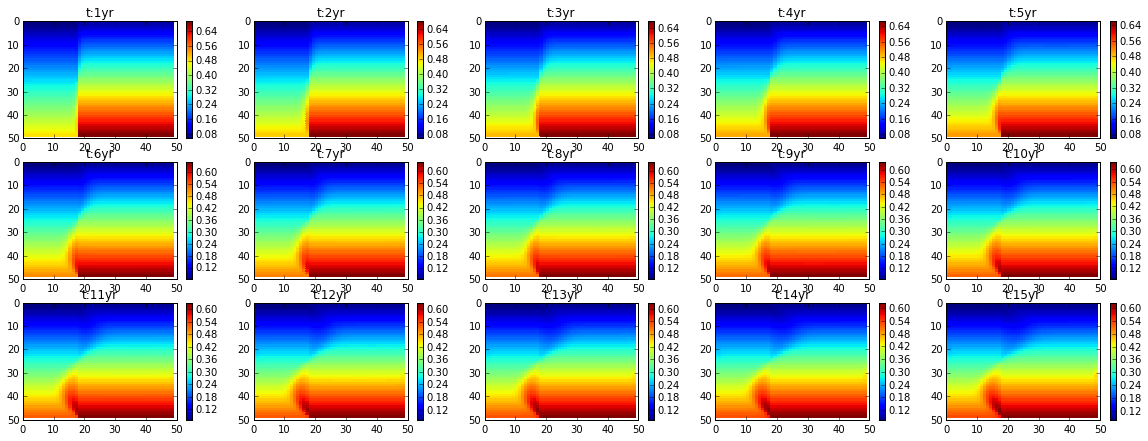

In [332]:
diss = disst[-1,:,:]
part= partt[-1,:,:]
disst= np.zeros((yr,Numpoints+4,Numpoints+4))
partt = np.zeros((yr,Numpoints+4,Numpoints+4))

fig = plt.figure(figsize=(20,50))
for j in range (t):
    diss,part=tracer(u,v,diss,part,1,4)
    k=(j+1)%coeff
    if k==0 and j!=0:
        disst[j/coeff,:,:]=diss
        partt[j/coeff,:,:]=part
        plot(diss,Numpoints,Numpoints,timestep=j/coeff,j1=20,j2=5,j3=j/coeff)
plt.show()

630.72


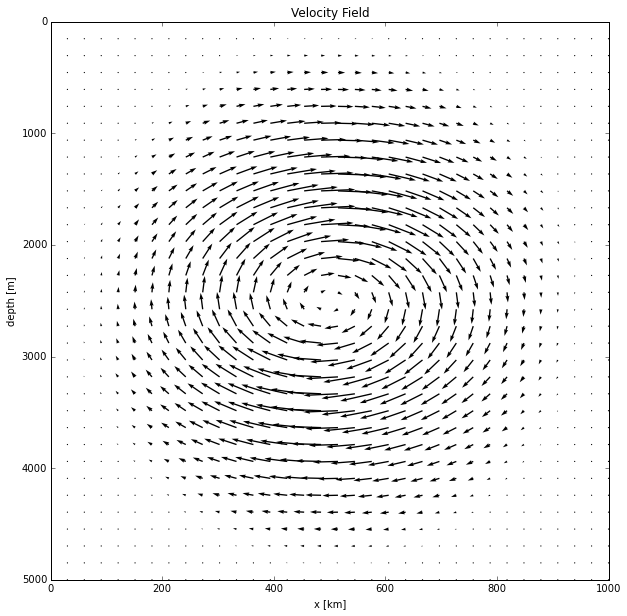

In [254]:
V = 0.02/1000*365.*86400.;xmin = 0;xmax = 1e6;zmin = 0;zmax = 5e3;nz = 34;nx = 34
u =flow.onecell_cen(xmin, xmax, zmin, zmax, nx, nz, V)

print V

x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
flowfig = plb.figure(figsize = (10,10))	
plb.quiver(x/1e3, z, u[1,:,:], -100*u[0,:,:])
plb.gca().invert_yaxis()
plt.title('Velocity Field')
plt.xlabel('x [km]')
plt.ylabel('depth [m]')
plt.show()